# Ketamine VR5 - SINGLE LABELED DATA ONLY
#### Jonathan Ramos 1/26/2024

I'm glad these data came just as I finished the sleep dep set so some of code is still fresh in my brain. For these data, the format of the csvs is quite different (due to the difference in the way PIPSQUEAK vs POLYGON spit out csvs). Col names are different and some label names need to be changed; in particular, some stain type names are simply called "hand drawn" if the user added ROIs that were not detected by the polygon algorithm. This causes probems because all hand drawn ROIs of any stain type are all called "hand drawn." This has been an on going issue with polygon, but we have a work around.

In the filename col, all files follow a consistent naming scheme:
- *_2.tif : PV
- *_3.tif : cFos
- *_4.tif : Npas4
- *_5.tif : WFA

Additionally, since there is no subject ID col, we can construct it from informatively named filenames instead. For this project, filenames follow the following format:

*(rat number)*_*(brain region)*_*(bregma)*_*(n)*.tif

In this notebook I will wrangle all the data into one spot (data is distributed over ~600 small csvs), clean things up, normalize intensity and count mean cell ns.



## Cleaning, Wrangling Data
### Loading data, stitching sets together

In [1]:
import numpy as np
import pandas as pd
import glob

# load cohort key (there's a few empty rows at the end)
df_key = pd.read_csv('KETAMINE_COHORT KEY.csv').dropna()

# load data; getting it all in one spot
df_full = pd.concat([pd.read_csv(f) for f in glob.glob('CSV_FILES/*/*.csv')])

# col names begin with a whitespace char; let's remove all ' ' chars from col names
df_full.columns = [col.replace(' ', '') for col in df_full.columns]

# let's take a look
df_full

/var/folders/b2/3h2lpxx14kgb12pp_7pltxnc0000gn/T/ipykernel_59275/1229073174.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,cell_number,roi_id,roi_source,roi_type,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,feret_angle,feret_min,circularity,aspect_ratio,roundness,solidity,skewness,kurtosis,filename,analysis_date
0,1,000-00000,Parvalbumin,OVAL,120.64,307.06,665.0,285.8023,636.1711,677.3578,...,0.0,28.0,0.9387,1.1447,0.8205,0.9419,-0.4228,-0.6905,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024
1,2,000-00001,Parvalbumin,OVAL,403.99,379.52,468.0,285.8023,412.1381,395.8835,...,90.0,24.0,0.8789,1.1555,0.7613,0.8797,0.4731,-0.5155,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024
2,3,000-00002,Parvalbumin,OVAL,363.44,463.29,399.0,285.8023,369.5932,366.851,...,0.0,20.0,0.8698,1.4266,0.6299,0.9027,0.3051,-0.1709,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024
3,4,000-00003,Parvalbumin,OVAL,68.43,322.91,550.0,285.8023,518.8725,540.6805,...,0.0,22.0,0.8089,1.6476,0.535,0.8814,-0.4078,-0.4258,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024
4,5,000-00004,Parvalbumin,OVAL,386.72,251.18,524.0,285.8023,832.9809,920.6865,...,0.0,26.0,0.9146,1.0654,0.8539,0.9066,-0.6879,-0.6308,PE-11-7_PFC_3.9_A_2.tif,Thu Jan 25 15:09:00 PST 2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,74,FFF-00073,hand-drawn,OVAL,491.39,60.52,130.0,541.3023,435.1857,415.7151,...,0.0,28.0,0.1835,1.1447,0.1604,0.1841,1.3612,1.5127,KET-10-4_PFC_3.5_C_4.tif,Mon Jan 22 16:14:32 PST 2024
74,75,FFF-00074,hand-drawn,OVAL,497.35,15.91,65.0,541.3023,413.2948,392.1778,...,0.0,28.0,0.0918,1.0617,0.0933,0.0921,3.3638,15.8851,KET-10-4_PFC_3.5_C_4.tif,Mon Jan 22 16:14:32 PST 2024
75,76,FFF-00075,hand-drawn,OVAL,437.04,376.98,130.0,541.3023,493.2017,462.339,...,0.0,28.0,0.1835,1.1447,0.1604,0.1841,1.4819,2.5275,KET-10-4_PFC_3.5_C_4.tif,Mon Jan 22 16:14:32 PST 2024
76,77,FFF-00076,hand-drawn,OVAL,472.11,432.2,104.0,541.3023,472.384,433.4397,...,0.0,28.0,0.1468,1.1447,0.1283,0.1473,1.6255,3.4102,KET-10-4_PFC_3.5_C_4.tif,Mon Jan 22 16:14:32 PST 2024


### Relabeling incorrect data

In [2]:
# there were some issues with the naming/cohort key 

# PE-12-7 was incorrectly labeled as PE-12-3; this was confirmed by JR and AG by checking slide books/hard copies of behavior data
df_full['filename'] = df_full.filename.replace({'PE-12-3': 'PE-12-7'}, regex=True)

# similarly KET-8-2 was incorrectly labeled as KET-8-5; this was confirmed by JR and AG  by checking slide books. this wouldn't really 
# change anything since they received the same treatment but let's just change it to the correct label anyway
df_full['filename'] = df_full.filename.replace({'KET-8-5': 'KET-8-2'}, regex=True)

# check result
assert df_full.filename.str.contains('PE-12-3').sum() == 0
assert df_full.filename.str.contains('PE-12-7').sum() != 0
assert df_full.filename.str.contains('KET-8-5').sum() == 0
assert df_full.filename.str.contains('KET-8-2').sum() != 0

### Building the necessary cols
In particular we will need a rat_n (sid) col, stain_type col, and a treatment col. the filename col functions as the image name (iid) col.

We need the following cols
- rat_n (sid)
- treatment
- filename (fid)
- imagename (iid)
- stain_type
- CoM_x
- CoM_y
- mean-background

In [3]:
# creating a new rat_n col
df_full['rat_n'] = df_full.filename.apply(lambda x: x.split('_')[0])\
    .replace({' ': ''}, regex=True) # for some reason, we have more leading whitespace chars

# some checks. we want be sure that the structure of all our rat_n labels is consistent
# in particular, we expect something of the form 'PE-12-7', that is we have exactly
# two dashes '-' separating some letters, followed by two numbers
assert df_full.rat_n.apply(lambda x: len(x.split('-')) == 3).sum() == len(df_full)
assert df_full.rat_n.apply(lambda x: x.split('-')[0].isalpha()).sum() == len(df_full)
assert df_full.rat_n.apply(lambda x: x.split('-')[1].isnumeric()).sum() == len(df_full)
assert df_full.rat_n.apply(lambda x: x.split('-')[2].isnumeric()).sum() == len(df_full)

# building a cohort key dictionary from df_key
treatment = dict(zip(df_key.Subject, df_key.TX.replace({' ': '_'}, regex=True)))

# creating new treatment col by mapping from cohort key dict
df_full['treatment'] = df_full.rat_n.map(treatment)

# creating new stain_type col from filename
stains = {
    '.*_2.tif$' : 'PV',
    '.*_3.tif$' : 'cFos',
    '.*_4.tif$' : 'Npas4',
    '.*_5.tif$' : 'WFA'
}
df_full['stain_type'] = df_full.filename.replace(stains, regex=True)

# check that stain_type col contains the appropriate labels
assert set(df_full.stain_type.unique()) == set(stains.values())

# building image name (iid) from file name (fid) col
df_full['image_name'] = df_full.filename.replace({'_[0-9]\.tif': ''}, regex=True)

df_subset = df_full[['rat_n', 'treatment', 'stain_type', 'filename', 'image_name', 'CoM_x', 'CoM_y', 'mean-background']]

# let's take a look
df_subset

,rat_n,treatment,stain_type,filename,image_name,CoM_x,CoM_y,mean-background
0,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,120.64,307.06,354.873
1,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,403.99,379.52,127.1692
2,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,363.44,463.29,86.6384
3,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,68.43,322.91,233.9562
4,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,386.72,251.18,547.2813
...,...,...,...,...,...,...,...,...
73,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,491.39,60.52,-106.9829
74,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,497.35,15.91,-120.9047
75,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,437.04,376.98,-49.6622
76,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,472.11,432.2,-67.7978


### Dropping nans, duplicates

In [4]:
# which cols have nans, how many?
print('Nan per col:')
print(df_subset.isna().sum())
# it looks like we have no nans! nothing to drop here.

# how many duplicated rows do we have?
print('\nTotal n of duplicated rows:')
print(df_subset.duplicated().sum())

# it looks like we have 15 duplicated rows. let's take a look 
df_full[df_subset.duplicated()].head(15)

# I'm not concerned about dropping these duplicates, so let's just toss em
df_cleaned = df_subset[~df_subset.duplicated()]
assert df_cleaned.duplicated().sum() == 0

Nan per col:
rat_n              0
treatment          0
stain_type         0
filename           0
image_name         0
CoM_x              0
CoM_y              0
mean-background    0
dtype: int64

Total n of duplicated rows:
15


## Removing cells with negative intensity

In [124]:
df_cleaned.loc[:, 'mean-background'] = df_cleaned['mean-background'].astype('f')
df_positive = df_cleaned[df_cleaned['mean-background'] > 0]
mint_gt_bg = df_full.query('mean_intensity > background')
print('total number of cells: \t\t\t\t\t\t', len(df_full))
print('number of cells with positive mean-background:\t\t\t', len(df_positive))
print('number of cells with mean_intensity greater than background: \t', len(mint_gt_bg))

total number of cells: 						 24613
number of cells with positive mean-background:			 7352
number of cells with mean_intensity greater than background: 	 7321


In [115]:
# why don't the above print statements agree?
npas4 = df_full.query('stain_type == "Npas4"')
wrong_math = npas4[npas4['mean-background'].astype('f') > 0].query('mean_intensity < background')[['roi_id', 'stain_type', 'filename', 'mean_intensity', 'background', 'mean-background']]
wrong_math['correct_subtraction (by hand)'] = wrong_math.mean_intensity - wrong_math.background
# wrong_math.to_csv('wrong_math.csv')

df_copy = df_full.copy(deep=True)
df_copy['correct_subtraction'] = df_full.mean_intensity - df_full.background
df_copy['difference'] = df_copy['mean-background'].astype('f') - df_copy.correct_subtraction
# df_copy[['rat_n', 'treatment', 'stain_type', 'image_name', 'filename', 'image_name', 'CoM_x', 'CoM_y',\
#           'mean_intensity', 'background', 'mean-background', 'correct_subtraction', 'difference']]\
#         .to_csv('Ketamine_single_label_corrected_subtraction.csv')

# descriptive stats of the differences
df_copy['difference'].describe()

count    24571.000000
mean         0.636140
std          6.153627
min        -96.231972
25%         -0.892497
50%          0.113886
75%          1.771140
max        286.666326
Name: difference, dtype: float64

For now, let's just continue on with the mean-background col that Polygon provides us with. I'll just look at the mean-background col and take only rows with positive values in this col

In [128]:
df_cleaned = df_cleaned[df_cleaned['mean-background'].astype('f') > 0].copy(deep=True)

,rat_n,treatment,stain_type,filename,image_name,CoM_x,CoM_y,mean-background
0,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,120.64,307.06,354.872986
1,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,403.99,379.52,127.169197
2,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,363.44,463.29,86.638397
3,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,68.43,322.91,233.956207
4,PE-11-7,VR5_KET,PV,PE-11-7_PFC_3.9_A_2.tif,PE-11-7_PFC_3.9_A,386.72,251.18,547.281311
...,...,...,...,...,...,...,...,...
4,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,13.18,218.34,22.122801
20,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,322.85,114.05,81.903999
36,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,289.63,251.79,138.050598
38,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_3.5_C_4.tif,KET-10-4_PFC_3.5_C,251.2,324.81,48.534698


## Normalizing Intensity
all parameterized functions will get set aside into module for future use and standardization.

In [5]:
def normalize_intensity(df, norm_condition):
    '''
    computes the mean of rows of the norm_condition and divides mean-background by this mean,
    normalizing all data to the mean of the norm_condition. sets normalized value into new
    column called "norm mean-background" and returns new dataframe containing normalized intensity.
    '''
    df_norm = df[df.treatment == norm_condition]
    norm_mean = df_norm['mean-background'].astype('f').mean()

    df_norm = df.copy(deep=True)
    df_norm['norm mean-background'] = df['mean-background'].astype('f') / norm_mean

    # quickly check that the mean of the norm condition is set to about 1.00000
    # this is never exatly 1 due to small rounding errors from floating point operations
    assert round(df_norm[df_norm.treatment == norm_condition]['norm mean-background'].mean(), 5) == 1
    
    return df_norm

def prism_reorg(df, group):
    '''
    Takes just the norm_mean-background intensity col per rat, groups by treatment
    and 
    '''
    treatments = np.unique(df.treatment)
    reorg = []

    for t in treatments:
        df_treat = df[df.treatment == t]
        norm_int_ratn = []
        treatment_ratns = np.unique(df_treat.rat_n)

        for rat in treatment_ratns:
            norm_int = df_treat[df_treat.rat_n == rat]['norm mean-background']
            df_normint = pd.DataFrame({t: norm_int}).reset_index(drop=True)
            norm_int_ratn.append(df_normint)

        # concat "vertically"
        df_ratn_cols = pd.concat(norm_int_ratn, axis=0).reset_index(drop=True)

        # write csv to disk
        reorg.append(df_ratn_cols)
    
    # concat "horizontally"
    df_prism_reorg = pd.concat(reorg, axis=1)

    
    # write csv to disk
    df_prism_reorg.to_csv(f'{group}_{np.unique(df.stain_type).item()}_{t}_PRISM.csv')

    return df_prism_reorg

def prism_reorg(df, group):
    '''
    Takes just the norm_mean-background intensity col per rat, groups by treatment
    and 
    '''
    treatments = np.unique(df.treatment)
    reorg = []

    for t in treatments:
        df_treat = df[df.treatment == t]
        norm_int_ratn = []
        treatment_ratns = np.unique(df_treat.rat_n)

        for rat in treatment_ratns:
            norm_int = df_treat[df_treat.rat_n == rat]['norm mean-background']
            df_normint = pd.DataFrame({t: norm_int}).reset_index(drop=True)
            norm_int_ratn.append(df_normint)

        # concat "vertically"
        df_ratn_cols = pd.concat(norm_int_ratn, axis=0).reset_index(drop=True)

        # write csv to disk
        reorg.append(df_ratn_cols)
    
    # concat "horizontally"
    df_prism_reorg = pd.concat(reorg, axis=1)

    return df_prism_reorg

    

## Counting Mean Cell Ns
Again, all parameterized functions will get set aside into module for future use and standardization

In [6]:
def count_imgs(df, sid, iid):
    '''
    takes a dataframe and counts the number of unique strings that occur in the 
    "image_name" col for each rat in "rat_n" col
    args:
        df: pd.core.frame.DataFrame(n, m) 
            n: the number of rows, 
            m: the number of features
        sid: str, denoting the name of the col containing unique subject ids
        iid: str, denoting the name of the col containing unique image ids
    return:
        df_imgn: pd.core.frame.DataFrame(n=|sid|), m=2)
            n: the number of rows, equal to the cardinality of the sid set
            (the number of unique ID strings in sid)
            this df contains 2 cols: a sid col, and an iid col containing counts
    '''
    assert iid in df.columns

    df_imgn = df.groupby([sid])[[sid, iid]]\
        .apply(lambda x: len(np.unique(x[iid])))\
        .reset_index(name='image_n')
    
    return df_imgn

def count_cells(df, cols):
    '''
    takes a df and counts the number of instances each distinct row 
    (created by unique combinations of labels from columns indicated
    by cols arg); counts are reported in a new col called "cell_counts"
    args:
        df: pd.core.frame.DataFrame(N, M); N: the number of rows, M: the
            number of cols (assumed to have already been split by stain_type)
        cols: list(n), n: the number of cols over which to count distinct rows
    return:
        df_counts: pd.core.frame.DataFrame(N,M+1)
    '''
    df_counts = df.value_counts(cols)\
        .reset_index(name='cell_counts')\
        .sort_values(by=cols)
    
    return df_counts

def sum_cells(df, cols, iid):
    '''
    takes cell count df, groups by cols denoted in cols list and computes sum
    of cell_counts col for each group. Adds new column "cell_count_sums"
    containing sums.
    args:
        df: pd.core.frame.DataFrame(N, M), N: the number of rows (N=|id_col|),
            M: the number of cols, must contain col called "cell_counts"
        cols: list(M-2), list containing col name strings that define each group 
            for group by and reduction (in this case summing)
        iid: str, denotes 
    return:
        df_sums: pd.core.frame.DataFrame; dataframe containing summed cell
            counts per subject id.
    '''
    # remove image id col (we want to sum counts across all images per rat)
    reduce_cols = list(filter(lambda x: x != iid, cols))

    if 'scaled_counts' in df.columns:
            # group by, reduce 
        df_sums = df.groupby(by=reduce_cols)[cols]\
            .apply(lambda x: np.sum(x.scaled_counts))\
            .reset_index(name='cell_count_sums')
    
    else:
        # group by, reduce 
        df_sums = df.groupby(by=reduce_cols)[df.columns]\
            .apply(lambda x: np.sum(x.cell_counts))\
            .reset_index(name='cell_count_sums')
    
    return df_sums

def average_counts(df_sums, df_ns, cols, sid, iid):
    '''
    takes df of cell count sums and df of image ns, and computes the mean cell 
    n (divides cell count sums by the number of images) for each subject.
    args:
        df_sums: pd.core.frame.DataFrame(ni, mi), ni: the number of rows
            (ni=|sid|), mi: the number of cols (mi = |cols|); must 
            contain a col "cell_count_sums". 
        df_ns: pd.core.frame.DataFrame(nj, mj), nj: the number of rows 
            (nj=|sid|), mj: the number of cols (mj=2); must contain a col
            "image_n" 
        cols: list(n), n: the number of cols (contains all cols necessary to 
            create every unique group combination)
        sid: str, denoting the name of the col containing unique subject ids
        iid: str, denoting the name of the col containing unique image ids
    return:
        mean_cell_ns: pd.core.frame.DataFrame(N,M), N: the number of rows (N=
        |sid|), M: the number of cols (M=|cols|+2)
        
    '''
    # list of cols with out image id, since it was removed during the reduction step
    reduce_cols = list(filter(lambda x: x != iid, cols))

    # compute mean cell n
    mean_cell_ns = df_sums.join(df_ns.set_index(sid), on=sid, how='inner')\
        .sort_values(by=reduce_cols)
    mean_cell_ns['mean_cell_n'] = mean_cell_ns.cell_count_sums / mean_cell_ns.image_n

    # reorder so that subject id is the first col
    col_reorder = [sid] + list(filter(lambda x: x != sid, list(mean_cell_ns.columns)))
    mean_cell_ns = mean_cell_ns[col_reorder]

    return mean_cell_ns

def mean_cell_n(df_stain, df_full, cols, sid, iid, return_counts=False):
    '''
    wrapper function to compute mean cell ns; magnification/zoom factor 
    is assuemd to be equal across all images. NOTE that we count total image
    ns based on full cleaned dataset: it may be the case the not every image
    contains every stain type combination, and we must still count images
    with 0 cells of a particular stain type towards the total number of images.
    args:
        df_stain: pd.core.frame.DataFrame; df containing data for a given stain type
        df_full: pd.core.frame.DataFrame; df containing data for full (cleaned) set
        cols: list, contains str denoting col names for grouping
        sid: str, col name denoting col containing unique subject ids
        iid: str, col name denoting col containing unique image ids
        return_counts: bool, flag for added utility during debugging
    return:
        mean_cell_ns: pd.core.frame.DataFrame; df containing final mean cell ns
        cell_counts: pd.core.frame. DataFram; df containing cell counts per
            image (for debugging)
        
    '''
    # count n of unique image names per subject
    img_ns = count_imgs(df_full, sid, iid)

    # count n of cells per image for each subject
    cell_counts = count_cells(df_stain, cols)

    # sum cell counts across all images for each subject
    cell_sums = sum_cells(cell_counts, cols, iid)

    # compute mean cell count per image for each subject
    mean_cell_ns = average_counts(cell_sums, img_ns, cols, sid, iid)

    if not return_counts:
        return mean_cell_ns
    
    return (cell_counts, mean_cell_ns)

## Time to run it!
#### Normalize Intensity, write to disk

In [7]:
grp = 'VR5_KET'
for stain in df_subset.stain_type.unique():

    # split by stain
    df_stain = df_subset[df_subset.stain_type == stain]

    # normalize to FR1_SAL
    df_norm = normalize_intensity(df_stain, norm_condition='FR1_SAL')
    df_norm.to_csv(f'{grp}_{stain}_single_NORM.csv')

    # reorganize into cols for prism
    df_prism = prism_reorg(df_norm, grp)
    df_prism.to_csv(f'{grp}_{stain}_PRISM.csv')

# let's take a look at one of our final output dataframes, organized for entry into prism
print(stain)
df_prism


WFA


,FR1_KET,FR1_SAL,VR5_KET,VR5_SAL
0,3.573138,5.740431,-1.730680,-0.584066
1,-0.228130,0.071669,-1.073475,-0.080524
2,0.373468,0.019555,-0.500109,-0.956723
3,-1.247351,3.060095,1.072946,-0.567922
4,0.126912,3.312895,-1.526467,-0.273813
...,...,...,...,...
354,NaN,NaN,-1.250855,NaN
355,NaN,NaN,1.005051,NaN
356,NaN,NaN,-1.339845,NaN
357,NaN,NaN,-1.134914,NaN


#### Count mean cell ns, write to disk

In [8]:
# count n of unique image names per subject
sid = 'rat_n'
iid = 'image_name'
cols = ['treatment', 'stain_type', sid, iid]

# wrapper fn calls
for stain in df_cleaned.stain_type.unique():
    
    # split by stain type
    df_stain = df_cleaned[df_cleaned.stain_type == stain]

    # compute mean cell ns
    df_means = mean_cell_n(df_stain, df_cleaned, cols, sid, iid)

    # write to disk
    df_means.to_csv(f'{grp}_{stain}_mean_cell_ns.csv')

# let's take a look at one of our final output dataframes
print(stain)
df_means


WFA


,rat_n,treatment,stain_type,cell_count_sums,image_n,mean_cell_n
0,KET-10-12,FR1_KET,WFA,32,5,6.40
1,KET-9-1,FR1_KET,WFA,29,4,7.25
2,PE-11-1,FR1_KET,WFA,20,5,4.00
3,PE-11-2,FR1_KET,WFA,25,5,5.00
4,PE-11-3,FR1_KET,WFA,46,5,9.20
5,PE-12-1,FR1_KET,WFA,26,5,5.20
6,PE-12-2,FR1_KET,WFA,39,5,7.80
7,PE-12-7,FR1_KET,WFA,47,5,9.40
8,KET-10-1,FR1_SAL,WFA,35,5,7.00
9,KET-10-5,FR1_SAL,WFA,32,5,6.40


# Negative Intensity?
I noticed that in the test output of the normalized intensities reshaped for prism, we were getting some negative values for normalized intensity. Negative values don't really make sense here. This would mean that the observed effect of the treatment results in cells actually being **dimmer** than background. 

The only way for negative numbers to arise here is if the mean intensity before background subtraction was **less than** the background at the time the image was captured. If the average signal in a selected region was less than (or not different from) background, that is its signal to noise ratio (SNR) is less than 1, it is unclear to me why we would consider this selection as an ROI. 

This means that either, selections were made where cells actually showed less fluorescence than background (did the stain work?), or background regions were poorly selected (did the background selection include ROIs?). 

### Distribution of dim selections across stain types

In [18]:
df_full = df_full[~df_full.duplicated()]
df_full['mean_intensity'] = df_full.mean_intensity.astype('f')

df_lt = df_full.query('mean_intensity < background')

print('total number of cells where mean intensity < background, per stain:')
print(df_lt.stain_type.value_counts())

print('\npercent of cells where mean intensity < background, per stain:')
print(df_lt.stain_type.value_counts() / df_full.stain_type.value_counts() * 100)

print('total number cells with negative mean-background')


total number of cells where mean intensity < background, per stain:
stain_type
Npas4    11324
cFos      4828
WFA        644
PV         466
Name: count, dtype: int64

percent of cells where mean intensity < background, per stain:
stain_type
Npas4    91.736876
PV       27.622999
WFA      55.517241
cFos     51.241775
Name: count, dtype: float64
total number cells with negative mean-background


7      -98.858
8     -55.6183
10    -29.2319
11    -56.5307
12    -119.333
        ...   
73   -106.9829
74   -120.9047
75    -49.6622
76    -67.7978
77   -119.9755
Name: mean-background, Length: 17262, dtype: object

### Distribution of dim selections across rats

In [10]:
print('\npercent cells where mean intensity < background, per rat:')
print(df_lt.rat_n.value_counts() / df_full.rat_n.value_counts() * 100)


percent cells where mean intensity < background, per rat:
rat_n
KET-10-1     65.707434
KET-10-12    68.518519
KET-10-14    63.389831
KET-10-2     53.207547
KET-10-3     60.782443
KET-10-4     68.148148
KET-10-5     63.955638
KET-8-2      62.178218
KET-8-7      69.841270
KET-9-1      72.389791
KET-9-2      74.835526
KET-9-4      81.145251
KET-9-5      69.240506
KET-9-6      59.211823
PE-11-1      70.720000
PE-11-2      75.552050
PE-11-3      75.396825
PE-11-4      71.587302
PE-11-5      82.324841
PE-11-6      79.788839
PE-11-7      81.153305
PE-12-1      69.776119
PE-12-2      71.132765
PE-12-7      68.951194
PE-13-1      80.444965
PE-13-11     66.795367
PE-13-2      71.444824
PE-13-3      79.567308
PE-13-6      79.648241
PE-13-9      78.071334
Name: count, dtype: float64


### A Closer Look at Pixel Area

In [11]:
df_full = df_full[~df_full.duplicated()]
df_max = df_full.groupby(['stain_type', 'image_name'])[['stain_type', 'image_name', 'pixel_area']]\
    .apply(lambda x: np.max(x.pixel_area))\
    .reset_index(name='max_pixel_area')\
    
df_avg_max = df_max.groupby('stain_type')[['stain_type', 'max_pixel_area']]\
    .apply(lambda x: np.average(x.max_pixel_area))\
    .reset_index(name='mean_max_pixel_area')

df_avg_max

,stain_type,mean_max_pixel_area
0,Npas4,1961.263514
1,PV,673.175676
2,WFA,1163.337838
3,cFos,402.837838


In [12]:
# means seem inflated by outliers; let's take a look at medians
df_median_max = df_max.groupby('stain_type')[['stain_type', 'max_pixel_area']]\
    .apply(lambda x: np.median(x.max_pixel_area))\
    .reset_index(name='median_max_pixel_area')

df_median_max

,stain_type,median_max_pixel_area
0,Npas4,520.5
1,PV,676.0
2,WFA,1147.5
3,cFos,385.5


In [13]:
# those means seem a little high. what is the maximum pixel area per stain type?
# means area likely driven up by outliers
df_full.groupby('stain_type')[['stain_type', 'pixel_area']]\
    .apply(lambda x: np.max(x.pixel_area))\
    .reset_index(name='max_pixel_area')

,stain_type,max_pixel_area
0,Npas4,28596.0
1,PV,1342.0
2,WFA,2264.0
3,cFos,763.0


In [14]:
# max pixel area for one cell of 28000 does not even make sense
# let's investigate those unusual, very large Npas4 cells
# something weird happened in these images
df_full.query('stain_type == "Npas4" & pixel_area > 1500')

,cell_number,roi_id,roi_source,roi_type,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,roundness,solidity,skewness,kurtosis,filename,analysis_date,rat_n,treatment,stain_type,image_name
4,5,200-00004,General Segmentation v1,POLYGON,238.33,249.59,28596.0,832.9028,717.443420,680.6517,...,0.1091,1.0,1.5587,2.9482,PE-11-5_PFC_3.9_B_4.tif,Thu Jan 25 15:00:50 PST 2024,PE-11-5,VR5_KET,Npas4,PE-11-5_PFC_3.9_B
5,6,200-00009,General Segmentation v1,POLYGON,245.39,259.26,27314.0,737.6275,621.745789,571.9613,...,0.1042,1.0,2.0482,5.4282,PE-11-4_PFC_3.6_D_4.tif,Thu Jan 25 14:55:25 PST 2024,PE-11-4,VR5_KET,Npas4,PE-11-4_PFC_3.6_D
4,5,200-00018,General Segmentation v1,POLYGON,270.94,238.52,27429.0,780.4174,675.169312,638.1753,...,0.1046,1.0,1.7441,3.9845,PE-11-6_PFC_3.9_A_4.tif,Thu Jan 25 15:03:53 PST 2024,PE-11-6,VR5_KET,Npas4,PE-11-6_PFC_3.9_A
5,6,200-00021,General Segmentation v1,POLYGON,270.94,238.52,27429.0,780.4174,675.169312,638.1753,...,0.1046,1.0,1.7441,3.9845,PE-11-6_PFC_3.9_A_4.tif,Thu Jan 25 15:03:53 PST 2024,PE-11-6,VR5_KET,Npas4,PE-11-6_PFC_3.9_A
6,7,200-00022,General Segmentation v1,POLYGON,270.94,238.52,27429.0,780.4174,675.169312,638.1753,...,0.1046,1.0,1.7441,3.9845,PE-11-6_PFC_3.9_A_4.tif,Thu Jan 25 15:03:53 PST 2024,PE-11-6,VR5_KET,Npas4,PE-11-6_PFC_3.9_A
7,8,200-00023,General Segmentation v1,POLYGON,270.94,238.52,27429.0,780.4174,675.169312,638.1753,...,0.1046,1.0,1.7441,3.9845,PE-11-6_PFC_3.9_A_4.tif,Thu Jan 25 15:03:53 PST 2024,PE-11-6,VR5_KET,Npas4,PE-11-6_PFC_3.9_A
0,1,200-00000,General Segmentation v1,POLYGON,271.7,252.53,23805.0,720.1612,618.770630,582.1547,...,0.0908,1.0,1.7792,4.2285,PE-11-4_PFC_3.8_B_4.tif,Thu Jan 25 14:56:51 PST 2024,PE-11-4,VR5_KET,Npas4,PE-11-4_PFC_3.8_B
0,1,200-00001,General Segmentation v1,POLYGON,250.45,273.55,26636.0,665.9866,580.254883,543.9764,...,0.1016,1.0,1.6087,3.1387,PE-13-1_PFC_3.6_E_4.tif,Thu Jan 25 15:43:05 PST 2024,PE-13-1,VR5_SAL,Npas4,PE-13-1_PFC_3.6_E
0,1,200-00000,General Segmentation v1,POLYGON,239.68,285.52,26845.0,316.7702,267.418701,233.0273,...,0.1024,1.0,3.1471,15.0826,KET-9-5_PFC_3.5_C_4.tif,Thu Jan 25 13:03:10 PST 2024,KET-9-5,FR1_SAL,Npas4,KET-9-5_PFC_3.5_C
8,9,200-00008,General Segmentation v1,POLYGON,279.49,250.82,27853.0,703.4017,579.480103,526.3982,...,0.1063,1.0,2.0342,5.1542,KET-10-4_PFC_4.1_A_4.tif,Mon Jan 22 16:20:19 PST 2024,KET-10-4,VR5_SAL,Npas4,KET-10-4_PFC_4.1_A


In [52]:
df_negative_counts = df_lt.groupby(['filename', 'stain_type'])[['filename', 'stain_type']]\
    .apply(lambda x: len(x.filename))\
    .reset_index(name='negative intensity counts')\
    .sort_values(by='negative intensity counts')

In [57]:
df_counts = df_full.groupby(['filename', 'stain_type'])[['filename', 'stain_type']]\
    .apply(lambda x: len(x.filename))\
    .reset_index(name='counts')\
    .sort_values(by='filename')

df_negative_counts.merge(df_counts).to_csv('negative_intensity_counts_by_file.csv')


# Dealing with negative intensities
## Median Split?

In [290]:
npas4 = df_full[df_full.stain_type == 'Npas4']
print(npas4.median_intensity.astype('f').median())

npas4.query('median_intensity == 437.85144')
print(len(npas4))

med_med_gt0 = npas4['mean-background'].astype('f') + npas4.median_intensity.astype('f').median() > 0
print(med_med_gt0.sum())

med_med_gt0 = npas4['mean-background'].astype('f') + npas4.mean_intensity.astype('f').median() > 0
print(med_med_gt0.sum())

437.85144
12344
12311
12311


In [163]:
# median of median intensity
test_img = npas4.query('filename == " PE-12-2_PFC_3.6_D_4.tif"')
med_int = test_img.median_intensity.astype('f').median()
med_int

444.28497

In [267]:
test_img_neg = test_img[test_img['mean-background'].astype('f') < 0]
test_img_neg_sorted = test_img_neg.sort_values(by='mean-background')
m = list(test_img_neg_sorted['mean-background'])[test_img_neg_sorted['mean-background'].count() // 2]

test_img['adjusted_mean-background'] = test_img['mean-background'].astype('f') + (-1*m)
test_img

/var/folders/b2/3h2lpxx14kgb12pp_7pltxnc0000gn/T/ipykernel_59275/525166263.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_img['adjusted_mean-background'] = test_img['mean-background'].astype('f') + (-1*m)


,cell_number,roi_id,roi_source,roi_type,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,skewness,kurtosis,filename,analysis_date,rat_n,treatment,stain_type,image_name,adjusted_mean-background,snr
0,1,200-00000,General Segmentation v1,POLYGON,417.96,499.13,350.0,572.0286,582.638611,554.322,...,0.7936,0.2897,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,107.973000,1.018548
1,2,200-00001,General Segmentation v1,POLYGON,267.27,458.34,757.0,572.0286,886.685120,871.4989,...,0.1222,-1.2742,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,405.441010,1.550071
2,3,200-00002,General Segmentation v1,POLYGON,45.88,450.17,193.0,572.0286,488.809296,461.5495,...,1.4261,2.5188,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,14.707001,0.854519
3,4,200-00003,General Segmentation v1,POLYGON,37.63,407.37,297.0,572.0286,453.547211,430.6313,...,1.6214,3.1709,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,-20.220901,0.792875
4,5,200-00004,General Segmentation v1,POLYGON,132.09,404.08,284.0,572.0286,499.338806,465.2783,...,0.8968,-0.0045,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,25.610504,0.872926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,106,FFF-00105,hand-drawn,OVAL,266.4,376.93,132.0,572.0286,518.463501,484.7022,...,1.2488,1.4826,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,46.297802,0.906359
106,107,FFF-00106,hand-drawn,OVAL,276.06,350.38,123.0,572.0286,474.718506,440.8519,...,2.0996,5.5607,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,0.525200,0.829886
107,108,FFF-00107,hand-drawn,OVAL,10.99,274.34,88.0,572.0286,457.285492,450.8587,...,1.1905,1.4763,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,-15.935799,0.799410
108,109,FFF-00108,hand-drawn,OVAL,348.03,55.62,59.0,572.0286,456.607208,418.0623,...,2.0806,5.3494,PE-12-2_PFC_3.6_D_4.tif,Thu Jan 25 15:35:18 PST 2024,PE-12-2,FR1_KET,Npas4,PE-12-2_PFC_3.6_D,-18.632698,0.798224


In [270]:
# ok so we keep 59 cells by adding back in the median of the mean_intensity to all cells
test_img[test_img['adjusted_mean-background'] > 0].shape

(59, 36)

## Let's try a different approach: dividing by background, rather than subtracting it
This way, we end up with a signal to noise  ratio (SNR) of intensity for each cell that can never be negative. ROI intensity can then be interpretted as a percent of background (SNR < 1 means that particular cell was dimmer than background). From here we can set/adjust a threshold based on SNR and assess how representative the new ROI selections/exclusions are of the cells we actually see in an image.
Then, the data taken to be normalized to some treatment condition will be the intensity SNR, and the mean of the norm group will be set to 1. 

After visual inspection by AG, JR, and BS, of the "worst offenders" (images with the greatest number of negative intensities), the following SNR cutoffs were deteremined to be appropriate:
 - Npas4:   0.8
 - PV:      0.8
 - WFA:     0.85
 - cFos:    0 (we want to keep all the data)

 In the following cells, I will plot exploratory histograms of the intensity SNRs for each stain type (single label only) and denote the determined cutoff with a red vertical line.

### Npas4

0.853451069345431


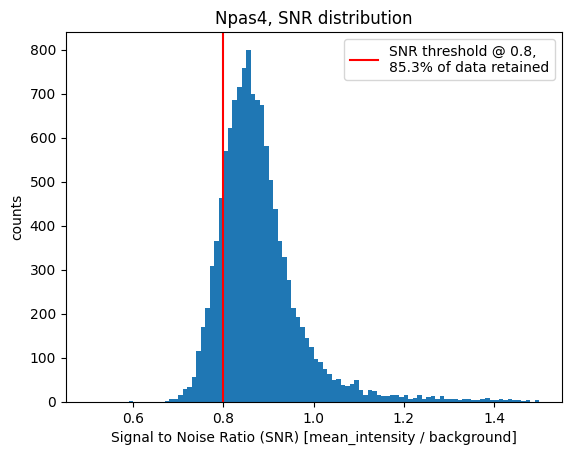

In [294]:
npas4 = df_full.query('stain_type == "Npas4"').copy(deep=True)

npas4['snr'] = npas4.loc[:, 'mean_intensity'].astype('f') / npas4.loc[:, 'background'].astype('f')
print(npas4.query('snr > 0.8').__len__() / npas4.__len__())
ret = np.round((npas4.query('snr > 0.8').__len__() / npas4.__len__()) * 100, 1)
plt.title('Npas4, SNR distribution')
plt.xlabel('Signal to Noise Ratio (SNR) [mean_intensity / background]')
plt.ylabel('counts')
plt.axvline(x=0.8, c='r', label =f'SNR threshold @ 0.8,\n{ret}% of data retained')
plt.legend()
plt.hist(npas4.snr, 100, range=[0.5, 1.5])
plt.savefig('Intensity_SNR_Distribution_Npas4.png', dpi=600)
plt.show()

### PV

0.941315945465323


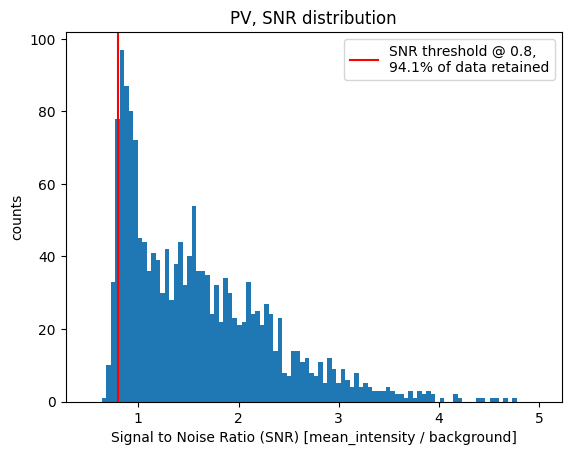

In [293]:
pv = df_full.query('stain_type == "PV"').copy(deep=True)

pv['snr'] = pv.loc[:, 'mean_intensity'].astype('f') / pv.loc[:, 'background'].astype('f')
print(pv.query('snr > 0.8').__len__() / pv.__len__())
ret = np.round((pv.query('snr > 0.8').__len__() / pv.__len__()) * 100, 1)

plt.title('PV, SNR distribution')
plt.xlabel('Signal to Noise Ratio (SNR) [mean_intensity / background]')
plt.ylabel('counts')
plt.axvline(x=0.8, c='r', label =f'SNR threshold @ 0.8,\n{ret}% of data retained')
plt.legend()
plt.hist(pv.snr, 100, range=[0.5, 5])
plt.savefig('Intensity_SNR_Distribution_PV.png', dpi=600)
plt.show()


### WFA

0.9818965517241379


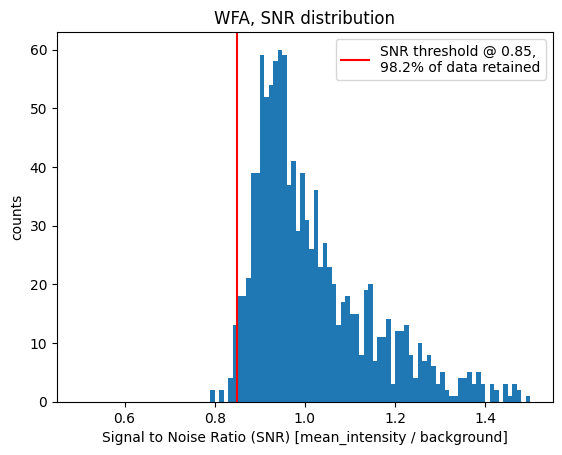

In [291]:
wfa = df_full.query('stain_type == "WFA"').copy(deep=True)

wfa['snr'] = wfa.loc[:, 'mean_intensity'].astype('f') / wfa.loc[:, 'background'].astype('f')
print(wfa.query('snr > 0.85').__len__() / wfa.__len__())
ret = np.round((wfa.query('snr > 0.85').__len__() / wfa.__len__()) * 100, 1)

plt.title('WFA, SNR distribution')
plt.xlabel('Signal to Noise Ratio (SNR) [mean_intensity / background]')
plt.ylabel('counts')
plt.axvline(x=0.85, c='r', label =f'SNR threshold @ 0.85,\n{ret}% of data retained')
plt.legend()
plt.hist(wfa.snr, 100, range=[0.5, 1.5])
plt.savefig('Intensity_SNR_Distribution_WFA.png', dpi=600)
plt.show()


### cFos
Upon visual inspection of some of the "worst offenders" for cFos, it was determined that all selected ROIs reasonably reflect the presence of true cells and so no SNR threshold will be applied.

0.9997877308427086


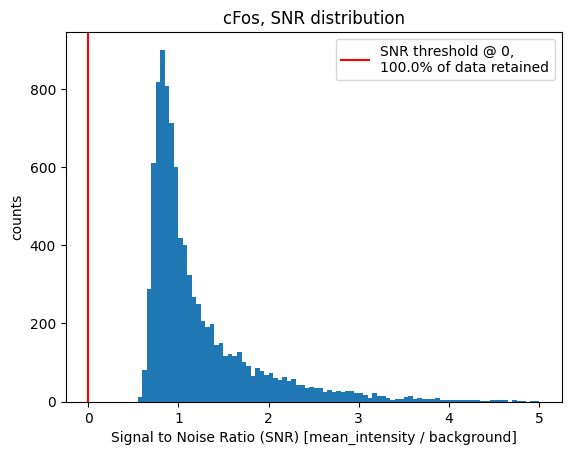

In [292]:
cfos = df_full.query('stain_type == "cFos"').copy(deep=True)

cfos['snr'] = cfos.loc[:, 'mean_intensity'].astype('f') / cfos.loc[:, 'background'].astype('f')
print(cfos.query('snr > 0').__len__() / cfos.__len__())
ret = np.round((cfos.query('snr > 0').__len__() / cfos.__len__()) * 100, 1)

plt.title('cFos, SNR distribution')
plt.xlabel('Signal to Noise Ratio (SNR) [mean_intensity / background]')
plt.ylabel('counts')
plt.axvline(x=0, c='r', label =f'SNR threshold @ 0,\n{ret}% of data retained')
plt.legend()
plt.hist(cfos.snr, 100, range=[0, 5])
plt.savefig('Intensity_SNR_Distribution_cFos.png', dpi=600)
plt.show()

Once I receive some updated data, I will repeat the wrangling/cleaning process for the single labeled ketamine data again, but this time implementing SNR thresholding as described above. 